<a href="https://colab.research.google.com/github/thesamasaurus/m19-ml-bot/blob/main/ML_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Model

## Importing modules 

In [ ]:
import os
import re
import pandas as pd
import copy
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Importing Data

In [ ]:
f = open("/content/gdrive/MyDrive/Colab Notebooks/test_data_save_batch_two", "rb")
test_dataset = pickle.load(f)

In [ ]:
g = open("/content/gdrive/MyDrive/Colab Notebooks/train_data_save_batch_two", "rb")
train_dataset = pickle.load(g)

In [ ]:
h = open("/content/gdrive/MyDrive/Colab Notebooks/index_data_save", "rb")
index_dataset = pickle.load(h)

In [ ]:
card_index = index_dataset["index"]
card_index_inverted = index_dataset["inverted"]

### Generating a inverted card index without spaces or numbers for easier exporting of results

In [ ]:
card_index_inverted_w_spaces = copy.deepcopy(card_index_inverted)
for i in range(0, 285):
    card_index_inverted_w_spaces[i] = card_index_inverted_w_spaces[i].replace("_", " ")
    card_index_inverted_w_spaces[i] = re.sub("\d", "", card_index_inverted_w_spaces[i])
    if (card_index_inverted_w_spaces[i][-1] == " "):
        card_index_inverted_w_spaces[i] = card_index_inverted_w_spaces[i][:-1]
card_index_inverted_w_spaces[175]

'Giant Spider'

### Generating dict of file names of images 

In [ ]:
card_index_imagenames = {}
for i in range(0, 285):
    card_index_imagenames[card_index_inverted_w_spaces[i]] = card_index_inverted_w_spaces[i]
    
for key, value in card_index_imagenames.items():
    
    card_index_imagenames[key] = card_index_imagenames[key].replace(" ", "-")
    card_index_imagenames[key] = card_index_imagenames[key].replace(",", "")
    card_index_imagenames[key] = card_index_imagenames[key].replace("'", "")
    card_index_imagenames[key] = card_index_imagenames[key].lower()
    card_index_imagenames[key] = card_index_imagenames[key] + ".jpg"
card_index_imagenames["Colossal Dreadmaw"]

'colossal-dreadmaw.jpg'

### defining function that takes onehot and spits out string representation

In [ ]:
def find_contense(one_hot):
    pack = []
    for i in range(0, len(one_hot)):
        if (one_hot[i] == 0):
            pass
        if (one_hot[i] > 0):
            for j in range(0, one_hot[i]):
                pack.append(card_index_inverted_w_spaces[i])
    return pack

In [ ]:
test = find_contense([0,1,1,0,1,1,0])
test

['Plains', 'Plains', 'Plains', 'Island']

#### Format of dict:  [ "pools" or "picks" or "packs" ] [ "draft_N" ] [ "player_1_pack_N_pick_N" ] - not zero indexed

In [ ]:
train_dataset["pools"]["draft_2"]["player_1_pack_1_pick_3"]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int8)

## Turning dict of drafts into arrays for training

In [ ]:
def create_pool_vectors(dataset):
    input_list = []
    for draft in range (0, len(dataset["pools"].keys())):
        for pack in range(1, 4):
            for pick in range(1, 16):
                input_list.append(dataset["pools"]["draft_" + str(draft)]["player_1_pack_" + str(pack) + "_pick_" + str(pick)])
    numpy_pools_array = np.asarray(input_list)
    return numpy_pools_array

In [ ]:
def create_packs_vectors(dataset):
    input_list = []
    for draft in range (0, len(dataset["packs"].keys())):
        for pack in range(1, 4):
            for pick in range(1, 16):
                input_list.append(dataset["packs"]["draft_" + str(draft)]["player_1_pack_" + str(pack) + "_pick_" + str(pick)])
    numpy_pools_array = np.asarray(input_list)
    return numpy_pools_array

In [ ]:
pools_array_train = create_pool_vectors(train_dataset)
pools_array_test = create_pool_vectors(test_dataset)

In [ ]:
pools_array_train[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int8)

In [ ]:
packs_array_train = create_packs_vectors(train_dataset)
packs_array_test = create_packs_vectors(test_dataset)

In [ ]:
len(packs_array_train)

1350000

In [ ]:
def create_picks_vectors(dataset):
    input_list = []
    for draft in range (0, len(dataset["packs"].keys())):
        for pack in range(1, 4):
            for pick in range(1, 16):
                input_list.append(dataset["picks"]["draft_" + str(draft)]["player_1_pack_" + str(pack) + "_pick_" + str(pick)])
    numpy_pools_array = np.asarray(input_list)
    return numpy_pools_array

In [ ]:
y_test = create_picks_vectors(test_dataset)
y_train = create_picks_vectors(train_dataset)

In [ ]:
len(y_train)

1350000

In [ ]:
def concatenate_arrays(pools_array, packs_array):
    input_list = []
    for i in range(0, len(pools_array)):
        temp = np.concatenate((pools_array[i], packs_array[i]))
        input_list.append(temp)
    numpy_input_array = np.asarray(input_list)
    return numpy_input_array

In [ ]:
input_test = concatenate_arrays(pools_array_test, packs_array_test)
input_train = concatenate_arrays(pools_array_train, packs_array_train)

## Building and training model

In [ ]:
model = Sequential([
    Dropout(0.8, input_shape=(570,)),
    Dense(units=2056, activation="relu"),
    Dense(units=2056, activation="relu"),
    Dense(units=2056, activation="relu"),
    Dense(units=2056, activation="relu"),
    Dense(units=285, activation="softmax"),
])


In [ ]:
# model = keras.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/keras_model_save_0.5871")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 570)               0         
_________________________________________________________________
dense (Dense)                (None, 2056)              1173976   
_________________________________________________________________
dense_1 (Dense)              (None, 2056)              4229192   
_________________________________________________________________
dense_2 (Dense)              (None, 2056)              4229192   
_________________________________________________________________
dense_3 (Dense)              (None, 2056)              4229192   
_________________________________________________________________
dense_4 (Dense)              (None, 285)               586245    
Total params: 14,447,797
Trainable params: 14,447,797
Non-trainable params: 0
____________________________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0000003), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [ ]:
model.fit(input_train, y_train, batch_size=16, epochs=25, verbose=1, shuffle=True )

Epoch 1/25
84375/84375 [==============================] - 399s 5ms/step - loss: 5.0894 - categorical_accuracy: 0.0299
Epoch 2/25
84375/84375 [==============================] - 397s 5ms/step - loss: 4.9822 - categorical_accuracy: 0.0421
Epoch 3/25
68827/84375 [=======================>......] - ETA: 1:12 - loss: 4.9157 - categorical_accuracy: 0.0556

In [ ]:
score=model.evaluate(input_test, y_test, verbose=2)
print(score)

NameError: ignored

In [ ]:
# model.save("/content/gdrive/MyDrive/Colab Notebooks/keras_model_save_0.5871")

## Examining Predictions

In [ ]:
def generate_string_prediction(draft):
    output = {}
    index_start = draft*45 
    index_end = draft*45 + 45 
    preds = model.predict(input_test[index_start:index_end])
    
    for i in range(index_start, index_end):
        pred_index = np.argmax(preds[i-index_start])
        pred_string = card_index_inverted_w_spaces[pred_index]
        output["pred_" + str(i-index_start+1)] = pred_string

    for pack in range(1, 4):
      for pick in range(1, 16):

        pool_string = find_contense(test_dataset["pools"]["draft_" + str(draft)]["player_1_pack_" + str(pack) + "_pick_" + str(pick)])
        pack_string = find_contense(test_dataset["packs"]["draft_" + str(draft)]["player_1_pack_" + str(pack) + "_pick_" + str(pick)])
        pick_string = find_contense(test_dataset["picks"]["draft_" + str(draft)]["player_1_pack_" + str(pack) + "_pick_" + str(pick)])
        pool_onehot = test_dataset["pools"]["draft_" + str(draft)]["player_1_pack_" + str(pack) + "_pick_" + str(pick)]
        pack_onehot = input_test[index_start+i][285:570]
        pick_onehot = test_dataset["picks"]["draft_" + str(draft)]["player_1_pack_" + str(pack) + "_pick_" + str(pick)]
        
        output["pool_" + str(((pack - 1) *15) + pick)] = pool_string
        output["pack_" + str(((pack - 1) *15) + pick)] = pack_string
        output["pick_" + str(((pack - 1) *15) + pick)] = pick_string
    
    return output

In [ ]:
test_test = generate_string_prediction(0)

In [ ]:
test_test["pack_4"]

['Submerged Boneyard',
 'Aven Wind Mage',
 'Sparktongue Dragon',
 "Knight's Pledge",
 'Scholar of Stars',
 'Pegasus Courser',
 'Recollect',
 'Catalyst Elemental',
 'Ghostform',
 'Root Snare',
 'Havoc Devils',
 'Mind Rot']

## Building image display functions

In [ ]:
def display_pack(index):
    array_of_images = []
    for card in test_output["pack_" + str(index)]:
        array_of_images.append(mpimg.imread('/content/gdrive/MyDrive/Colab Notebooks/m19_images/' +card_index_imagenames[card]))
    fig = plt.figure(figsize=(26, 13))
    for i in range(len(array_of_images)):
        b = array_of_images[i]
        fig.add_subplot(3, 5, i+1)
        plt.imshow(b)
        plt.axis("off")
    plt.show()
    return

In [ ]:
def display_pick(index):
    array_of_images = []
    for card in test_output["pick_" + str(index)]:
        array_of_images.append(mpimg.imread('/content/gdrive/MyDrive/Colab Notebooks/m19_images/' +card_index_imagenames[card]))
    fig = plt.figure(figsize=(22, 11))
    for i in range(len(array_of_images)):
        b = array_of_images[i]
        fig.add_subplot(3, 5, i+1)
        plt.imshow(b)
        plt.axis("off")
    plt.show()
    return

In [ ]:
def display_pool(index):
    array_of_images = []
    for card in test_output["pool_" + str(index)]:
        array_of_images.append(mpimg.imread('/content/gdrive/MyDrive/Colab Notebooks/m19_images/' +card_index_imagenames[card]))
    fig = plt.figure(figsize=(30, 15))
    for i in range(len(array_of_images)):
        b = array_of_images[i]
        fig.add_subplot(3, 15, i+1)
        plt.imshow(b)
        plt.axis("off")
    plt.show()
    return

In [ ]:
def display_pred(index):
    array_of_images = []
    card = test_output["pred_" + str(index)]
    array_of_images.append(mpimg.imread('/content/gdrive/MyDrive/Colab Notebooks/m19_images/' +card_index_imagenames[card]))
    fig = plt.figure(figsize=(40, 20))
    for i in range(len(array_of_images)):
        b = array_of_images[i]
        fig.add_subplot(3, 15, i+1)
        plt.imshow(b)
        plt.axis("off")
    plt.show()
    return

In [ ]:
def display_all(index):
    print("Pack"), display_pack(index), print("Prediction"), display_pred(index),  print("Human Pick"), display_pick(index), print("Pool"), display_pool(index),
    return

In [ ]:
test_output = generate_string_prediction(420) #just change # to which draft u want to view

Pack


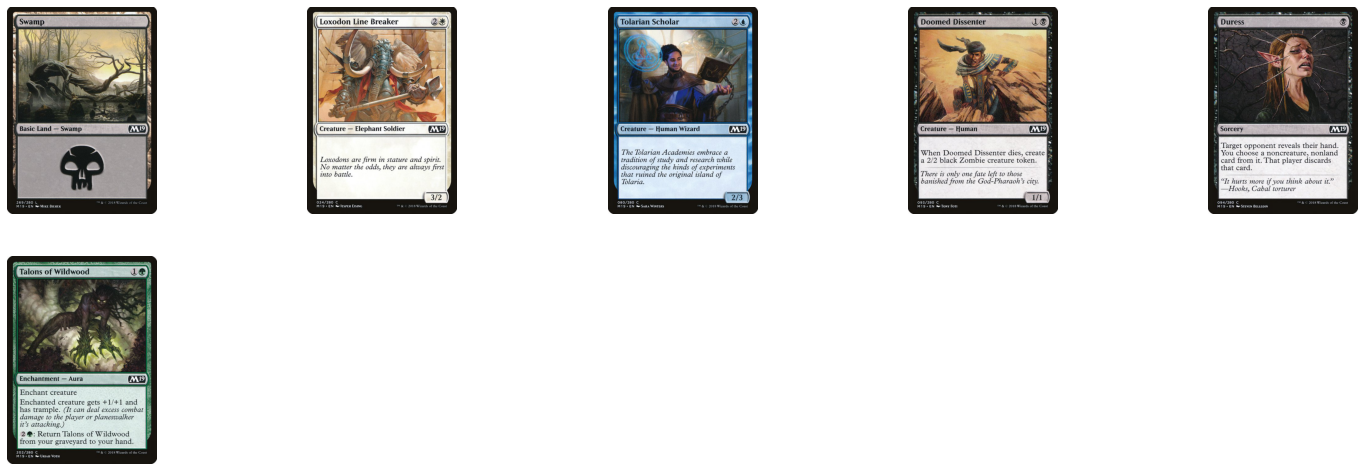

Prediction


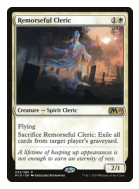

Human Pick


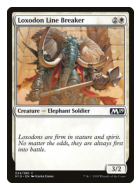

Pool


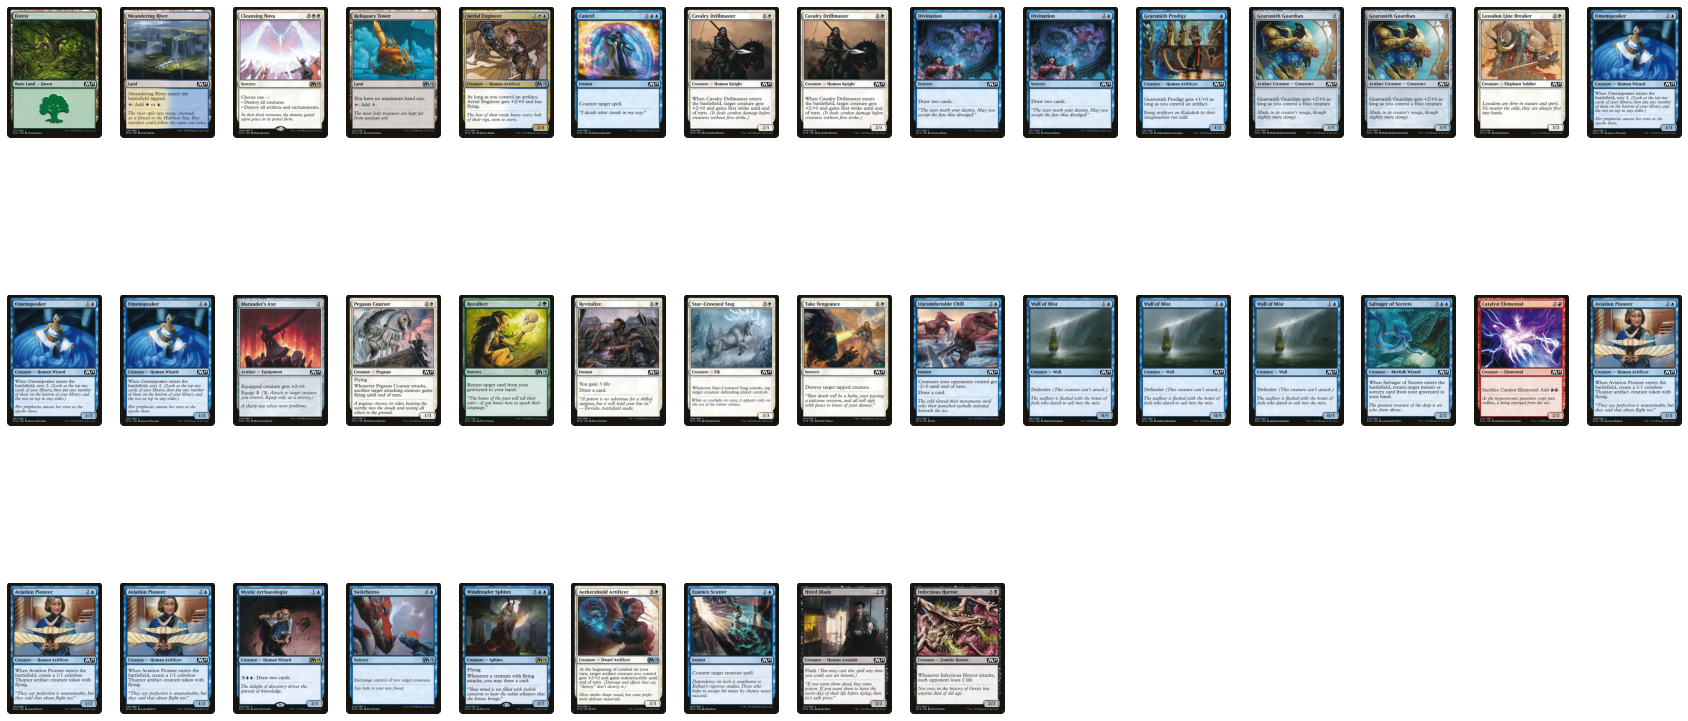

In [ ]:
display_all(40) #put any number between 0 and 45 here to see the pick in that draft, 1-45

In [ ]:
pick_order = copy.deepcopy(input_test[0:2])
pick_order[0][pick_order[0] > 0] = 0
pick_order[1][pick_order[0] > 0] = 0
pick_order[0]

pick_order = model.predict(pick_order)

In [ ]:
named_pick_order = []
for i in range(0, len(pick_order[0])):
  pick_tuple = (card_index_inverted_w_spaces[i], pick_order[0][i])
  named_pick_order.append(pick_tuple)

In [ ]:
named_pick_order

[('Plains', 0.0035087613),
 ('Plains', 0.0035087618),
 ('Plains', 0.0035087578),
 ('Plains', 0.003508749),
 ('Plains', 0.0035087531),
 ('Island', 0.0035087625),
 ('Island', 0.0035087804),
 ('Island', 0.0035087874),
 ('Island', 0.0035087697),
 ('Island', 0.0035087576),
 ('Swamp', 0.003508742),
 ('Swamp', 0.0035087508),
 ('Swamp', 0.00350877),
 ('Swamp', 0.0035087771),
 ('Swamp', 0.003508785),
 ('Mountain', 0.0035087592),
 ('Mountain', 0.0035087673),
 ('Mountain', 0.0035087653),
 ('Mountain', 0.0035087608),
 ('Mountain', 0.0035087622),
 ('Forest', 0.0035087508),
 ('Forest', 0.0035087666),
 ('Forest', 0.0035087646),
 ('Forest', 0.0035087685),
 ('Forest', 0.0035087697),
 ('Cinder Barrens', 0.0035087569),
 ('Forsaken Sanctuary', 0.0035087953),
 ('Foul Orchard', 0.0035087704),
 ('Highland Lake', 0.003508766),
 ('Meandering River', 0.003508775),
 ('Stone Quarry', 0.0035087755),
 ('Submerged Boneyard', 0.0035087864),
 ('Tranquil Expanse', 0.0035087669),
 ('Woodland Stream', 0.0035087755),
 ('T

In [ ]:
sorted_pick_order = sorted(named_pick_order, key=lambda tup: tup[1])

In [ ]:
sorted_pick_order

[('Swamp', 0.003508742),
 ('Phylactery Lich', 0.003508743),
 ('Detection Tower', 0.0035087445),
 ('Mentor of the Meek', 0.0035087452),
 ('Sleep', 0.0035087473),
 ('Isareth the Awakener', 0.0035087483),
 ('Scapeshift', 0.0035087485),
 ('Arcane Encyclopedia', 0.0035087487),
 ('Plains', 0.003508749),
 ('Goblin Trashmaster', 0.003508749),
 ("Liliana's Contract", 0.003508749),
 ('Arcades, the Strategist', 0.0035087497),
 ('Palladia-Mors, the Ruiner', 0.0035087503),
 ('Vine Mare', 0.0035087503),
 ('Volley Veteran', 0.0035087503),
 ('Swamp', 0.0035087508),
 ('Forest', 0.0035087508),
 ('Diamond Mare', 0.003508752),
 ('Sigiled Sword of Valeron', 0.0035087522),
 ('Colossal Majesty', 0.0035087522),
 ('Switcheroo', 0.0035087522),
 ('Elvish Clancaller', 0.0035087524),
 ('Plains', 0.0035087531),
 ('Declare Dominance', 0.0035087531),
 ('Windreader Sphinx', 0.003508754),
 ('Surge Mare', 0.0035087543),
 ('Prodigious Growth', 0.0035087545),
 ('Dismissive Pyromancer', 0.0035087545),
 ('Liliana, Untouched